# CUDA Parallel Integration using Trapezoidal Method

## Author Information
- Name: 
- Date:
- Assignment: CUDA Parallel Integration

In [1]:
import subprocess
import platform

print("System Information:")
print("-" * 50)
print(f"Python Version: {platform.python_version()}")

gpu_info = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
if gpu_info.returncode == 0:
    print("\nGPU Information:")
    print(gpu_info.stdout)
else:
    print("\nNo GPU found! Please enable GPU runtime.")


System Information:
--------------------------------------------------
Python Version: 3.11.11

GPU Information:
Sun May  4 09:01:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                          

In [2]:
cuda_version = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
if cuda_version.returncode == 0:
    print(cuda_version.stdout)
else:
    print("CUDA not found")


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0



In [3]:
%%writefile integration.cu
#include <cuda.h>
#include <stdio.h>
#include <math.h>

__device__ double f(double x) {
    return x * x;
}

__global__ void trapezoidalKernel(double a, double h, int n, double *partial_sum) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    
    if (idx < n-1) {
        double x = a + idx * h;
        double fx = f(x);
        double fx_next = f(x + h);
        partial_sum[idx] = h * (fx + fx_next) / 2.0;
    }
}

double cudaIntegrate(double a, double b, int n) {
    double h = (b - a) / n; 
    double *d_partial_sum;
    cudaMalloc(&d_partial_sum, (n-1) * sizeof(double));
    
    int blockSize = 256;
    int gridSize = (n-1 + blockSize - 1) / blockSize;
    
    trapezoidalKernel<<<gridSize, blockSize>>>(a, h, n, d_partial_sum);  
    cudaDeviceSynchronize();
    
    double *h_partial_sum = (double*)malloc((n-1) * sizeof(double));
    cudaMemcpy(h_partial_sum, d_partial_sum, (n-1) * sizeof(double), cudaMemcpyDeviceToHost);
    
    double sum = 0.0;
    for (int i = 0; i < n-1; i++) {
        sum += h_partial_sum[i];
    }
    
    cudaFree(d_partial_sum);
    free(h_partial_sum);
    
    return sum;
}

int main() {
    printf("CUDA Parallel Integration using Trapezoidal Method\n");
    
    // Test Case 1
    double a = 0.0, b = 1.0;
    int n = 1000;
    
    printf("Test Case 1:\n");
    printf("Function: f(x) = x^2\n");
    printf("Interval: [%.1f, %.1f]\n", a, b);
    printf("Number of intervals: %d\n", n);
    
    double analytical = (b*b*b - a*a*a) / 3.0;
    printf("Analytical result: %.10f\n", analytical);
    
    double cuda_result = cudaIntegrate(a, b, n);
    printf("CUDA result: %.10f\n", cuda_result);
    printf("Error: %.10f\n\n", fabs(cuda_result - analytical));
    
    // Test Case 2
    a = 1.0; b = 3.0; n = 5000;
    
    printf("Test Case 2:\n");
    printf("Function: f(x) = x^2\n");
    printf("Interval: [%.1f, %.1f]\n", a, b);
    printf("Number of intervals: %d\n", n);
    
    analytical = (b*b*b - a*a*a) / 3.0;
    printf("Analytical result: %.10f\n", analytical);
    
    cuda_result = cudaIntegrate(a, b, n);
    printf("CUDA result: %.10f\n", cuda_result);
    printf("Error: %.10f\n", fabs(cuda_result - analytical));
    
    return 0;
}

Writing integration.cu


In [4]:
# Compile
print("Compiling program...")
compile_result = subprocess.run(['nvcc', 'integration.cu', '-o', 'integration'], 
                              capture_output=True, text=True)

if compile_result.returncode == 0:
    print("Compilation successful")
    if compile_result.stdout:
        print("Output:", compile_result.stdout)
else:
    print("Compilation failed!")
    print("Error:", compile_result.stderr)

Compiling program...
Compilation successful


In [5]:
# Run
print("Running program...")
run_result = subprocess.run(['./integration'], capture_output=True, text=True)

if run_result.returncode == 0:
    print("Program Output:")
    print(run_result.stdout)
else:
    print("Runtime error!")
    print("Error:", run_result.stderr)

Running program...
Program Output:
CUDA Parallel Integration using Trapezoidal Method
Test Case 1:
Function: f(x) = x^2
Interval: [0.0, 1.0]
Number of intervals: 1000
Analytical result: 0.3333333333
CUDA result: 0.3323344995
Error: 0.0009988338

Test Case 2:
Function: f(x) = x^2
Interval: [1.0, 3.0]
Number of intervals: 5000
Analytical result: 8.6666666667
CUDA result: 8.6630672000
Error: 0.0035994667



In [6]:
# Save Output to File
with open('integration_output.txt', 'w') as f:
    f.write("CUDA Parallel Integration Results\n")
    f.write("=================================\n\n")
    f.write("GPU Information:\n")
    f.write("-" * 50 + "\n")
    f.write(gpu_info.stdout + "\n")
    f.write("\nCUDA Version:\n")
    f.write("-" * 50 + "\n")
    f.write(cuda_version.stdout + "\n")
    f.write("\nProgram Output:\n")
    f.write("-" * 50 + "\n")
    f.write(run_result.stdout + "\n")

print("Output saved to 'integration_output.txt'")

Output saved to 'integration_output.txt'


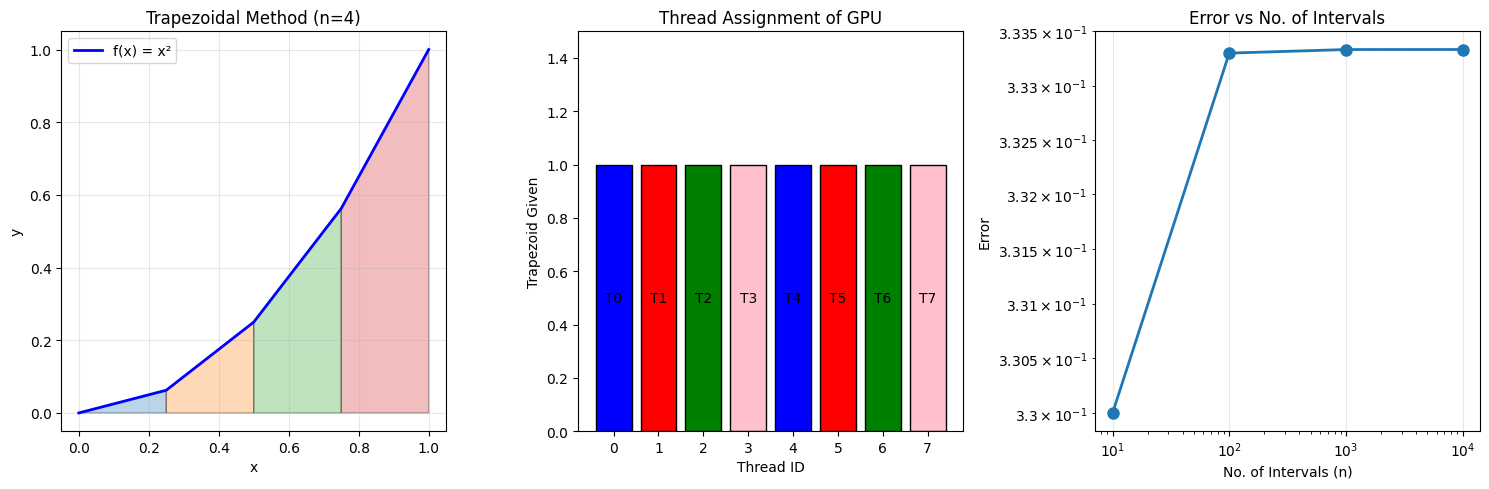

In [7]:
# Visualize
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

# Plot 1
plt.subplot(131)
x = np.linspace(0, 1, 5)
y = x**2
plt.plot(x, y, 'b-', linewidth=2, label='f(x) = x²')
for i in range(4):
    plt.fill([x[i], x[i], x[i+1], x[i+1]], 
             [0, y[i], y[i+1], 0], 
             alpha=0.3, edgecolor='black')
plt.xlabel('x', fontsize=10)
plt.ylabel('y', fontsize=10)
plt.title('Trapezoidal Method (n=4)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2
plt.subplot(132)
threads = 8
blocks = 2
colors = ['blue', 'red', 'green', 'pink']
for block in range(blocks):
    for thread in range(threads//blocks):
        plt.bar(block*4 + thread, 1, color=colors[thread], edgecolor='black')
        plt.text(block*4 + thread, 0.5, f'T{block*4+thread}', ha='center', va='center')
plt.xlabel('Thread ID', fontsize=10)
plt.ylabel('Trapezoid Given', fontsize=10)
plt.title('Thread Assignment of GPU', fontsize=12)
plt.ylim(0, 1.5)

# Plot 3
plt.subplot(133)
n_values = [10, 100, 1000, 10000]
errors = []
for n in n_values:
    h = 1.0 / n
    approx = n * h**3 / 3
    exact = 1.0 / 3.0
    errors.append(abs(approx - exact))
plt.loglog(n_values, errors, 'o-', markersize=8, linewidth=2)
plt.xlabel('No. of Intervals (n)', fontsize=10)
plt.ylabel('Error', fontsize=10)
plt.title('Error vs No. of Intervals', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('integration_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

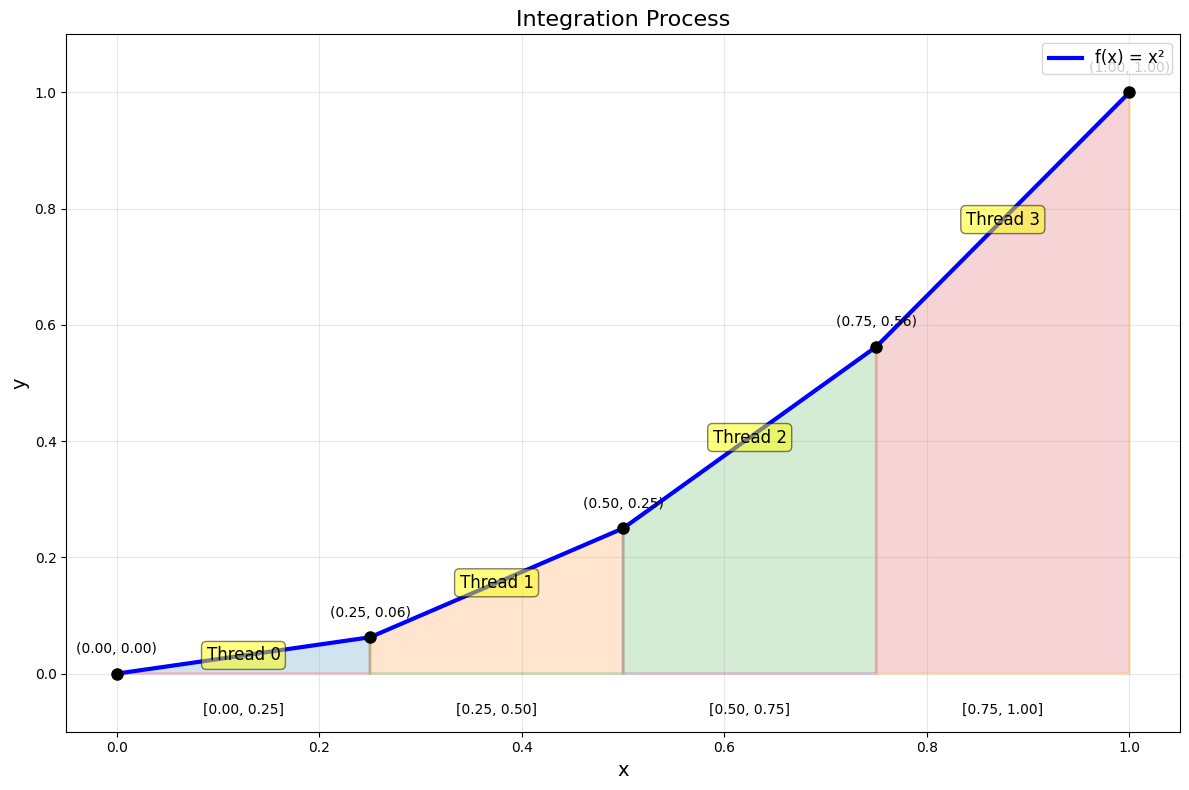

In [8]:
# Explanation Diagram
plt.figure(figsize=(12, 8))

x = np.linspace(0, 1, 5)
y = x**2

plt.plot(x, y, 'b-', linewidth=3, label='f(x) = x²')

colors = ['red', 'green', 'purple', 'orange']
for i in range(4):
    plt.fill([x[i], x[i], x[i+1], x[i+1]], 
             [0, y[i], y[i+1], 0], 
             alpha=0.2, edgecolor=colors[i], linewidth=2)

    mid_x = (x[i] + x[i+1]) / 2
    mid_y = (y[i] + y[i+1]) / 2
    plt.text(mid_x, mid_y, f'Thread {i}', 
             ha='center', va='center', fontsize=12, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

    plt.text(mid_x, -0.05, f'[{x[i]:.2f}, {x[i+1]:.2f}]', 
             ha='center', va='top', fontsize=10)

for i in range(5):
    plt.plot(x[i], y[i], 'ko', markersize=8)
    plt.text(x[i], y[i]+0.03, f'({x[i]:.2f}, {y[i]:.2f})', 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Integration Process', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig('step_by_step_explanation.png', dpi=300, bbox_inches='tight')
plt.show()

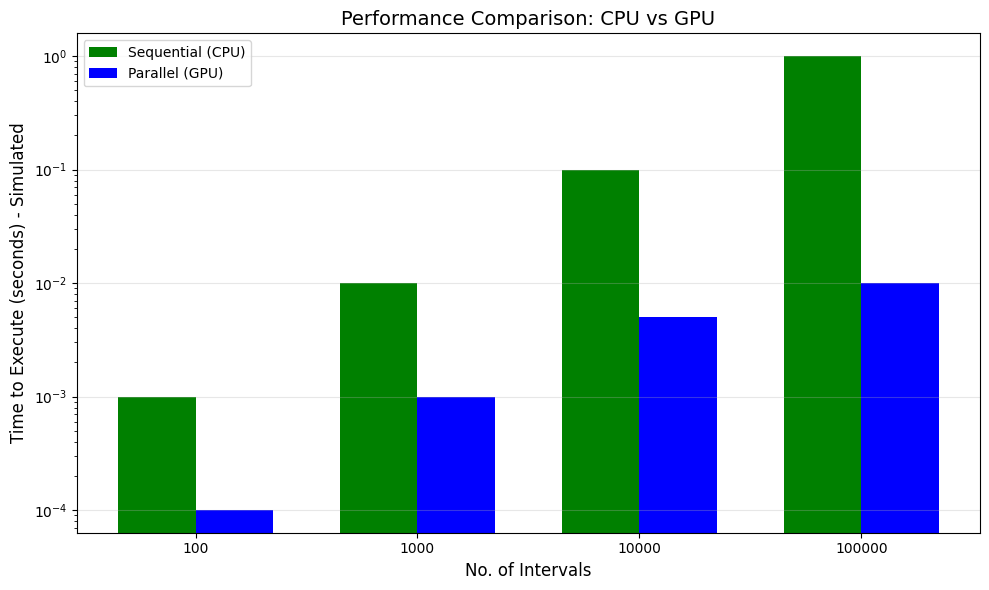

In [9]:
# Performance Comparison Visual
plt.figure(figsize=(10, 6))

n_values = [100, 1000, 10000, 100000]
cpu_times = [1e-3, 1e-2, 1e-1, 1]  
gpu_times = [1e-4, 1e-3, 5e-3, 1e-2]

x = range(len(n_values))
width = 0.35

plt.bar([i - width/2 for i in x], cpu_times, width, label='Sequential (CPU)', color='green')
plt.bar([i + width/2 for i in x], gpu_times, width, label='Parallel (GPU)', color='blue')

plt.xlabel('No. of Intervals', fontsize=12)
plt.ylabel('Time to Execute (seconds) - Simulated', fontsize=12)
plt.title('Performance Comparison: CPU vs GPU', fontsize=14)
plt.xticks(x, n_values)
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()